In [1]:
import numpy as np
import numpy.linalg as la
import scipy.signal as sig
import scipy.integrate as integ
import scipy.interpolate as interp
import scipy.stats as stats
import matplotlib.pyplot as plt
import cv2 as cv
from mpl_toolkits.mplot3d import Axes3D
from scipy import io as spio
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
plt.style.use("bmh")
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["text.latex.preamble"] = [r"\usepackage{physics}", r"\usepackage{url}"]

In [3]:
f = 3.04 # mm
b = 5 # mm

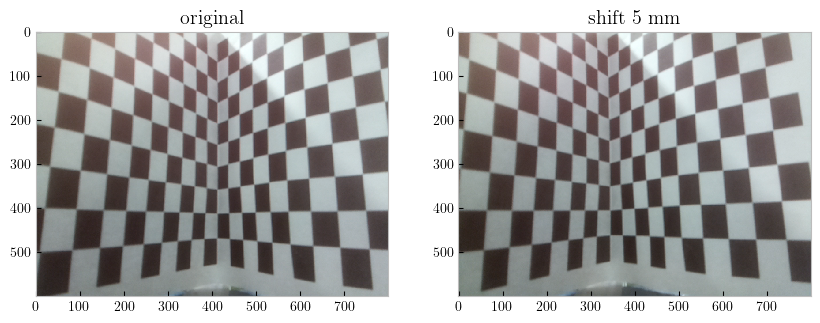

In [4]:
# Display original and shifted images
img = cv.imread('image.png')
dimg = cv.imread('image_offset.png')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
dgray = cv.cvtColor(dimg, cv.COLOR_BGR2GRAY)
    
fig, ax = plt.subplots(1, 2, figsize=(5*2, 5))

ax[0].imshow(img)
ax[0].grid(0)
ax[0].set_title('original')

ax[1].imshow(dimg)
ax[1].grid(0)
ax[1].set_title('shift 5 mm')

# plt.savefig('chosen_corners.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# Tabulate corresponding image coordinates of specific corner points from both images
x1 = np.array([[411, 29],
               [410, 210],
               [264, 143],
               [121, 83],
               [266, 26],
               [335, 17],
               [562, 147],
               [780, 87],
               [601, 12],
               [710, 36],
               [763, 588],
               [583, 559],
               [411, 529],
               [280, 553],
               [136, 580],
               [732, 245],
               [109, 234]
              ])
x2 = np.array([[338, 16],
               [342, 200],
               [183, 130],
               [25,  65],
               [184, 9],
               [257, 1],
               [490, 139],
               [696, 82],
               [527, 5],
               [631, 31],
               [684, 561],
               [514, 543],
               [345, 522],
               [208, 554],
               [52,  591],
               [650, 236],
               [12, 226]
              ])

In [6]:
# Get some corner points from Camera Calibration activity
# Get world and image coordinates of points along the same x coordinates (dox & dix)
# Get world and image coordinates of points along the same y coordinates (doy & diy)
dox = np.array([[ 0 , 5 , 4 ], # 20
                [ 0 , 3 , 4 ], # 21
                [ 0 , 1 , 4 ], # 22
                [ 0 , 0 , 4 ], # 23
                [ 0 , 2 , 4 ]  # 24
               ]) * 13 # mm
doy = np.array([[ 0 , 2 , 7 ], # 9
                [ 0 , 2 , 5 ], # 18
                [ 0 , 2 , 4 ], # 24
                [ 0 , 2 , 2 ]  # 25
               ]) * 13 # mm
dix = np.array([[564., 274.],
                [490., 290.],
                [433., 304.],
                [409., 304.],
                [465., 349.]
               ])
diy = np.array([[463., 133.],
                [464., 237.],
                [465., 349.],
                [468., 413.]
               ])

In [7]:
# Linear regression to get pixel-to-mm calibration for x & y directions
mx, bx, Rx, _, __ = stats.linregress(dix[:,0], dox[:,1])
my, by, Ry, _, __ = stats.linregress(diy[:,1], doy[:,2])

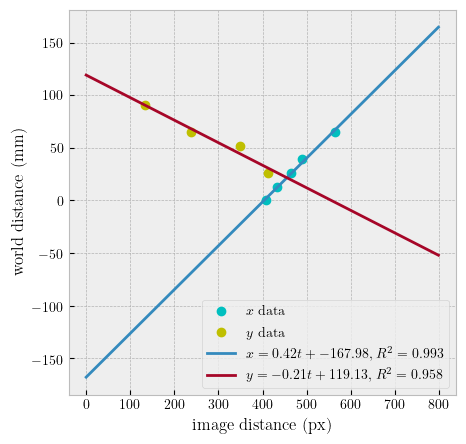

In [8]:
# Plot calibration curves
t = np.arange(800)
plt.plot(dix[:,0], dox[:,1], 'co')
plt.plot(diy[:,1], doy[:,2], 'yo')
plt.plot(t, mx*t + bx)
plt.plot(t, my*t + by)
plt.legend(['$x$ data',
            '$y$ data',
            '$x = %.2ft + %.2f$, $R^2 = %.3f$'%(mx, bx, Rx**2),
            '$y = %.2ft + %.2f$, $R^2 = %.3f$'%(my, by, Ry**2),
           ])
plt.ylabel('world distance (mm)')
plt.xlabel('image distance (px)')
plt.show()

In [11]:
# Solve eq (3) from handouts
def fZ(x1, x2):
    return b*f/(x2 - x1)

z = fZ(mx*x1[:,0] + bx, mx*x2[:,0] + bx)

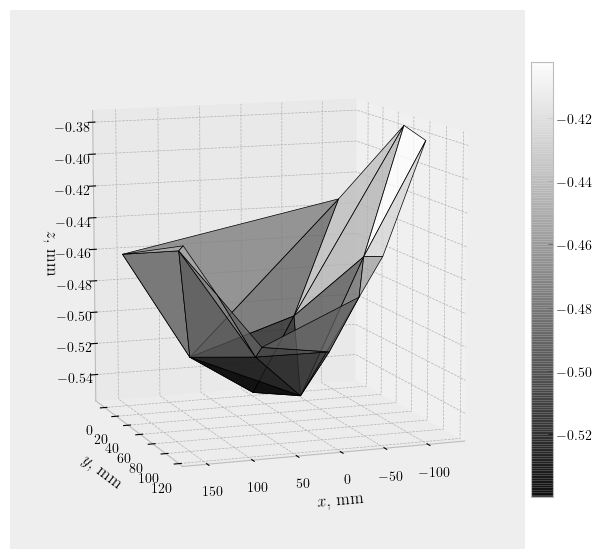

In [13]:
# Plot reconstructed 3D shape (automatic interpolation via Delaunay triangulation)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(mx*x1[:,0] + bx, 
                       my*x1[:,1] + by, 
                       z, 
                       cmap='gray', edgecolor='k', lw=0.5, alpha=0.75)
ax.set_xlabel('$x$, mm')
ax.set_ylabel('$y$, mm')
ax.set_zlabel('$z$, mm')
fig.colorbar(surf, pad=0.01, fraction=0.04)
for i, (e, a) in enumerate(zip([90, 30, 30, 10], [90, 120, 70, 70])):
    ax.view_init(elev=e, azim=a)
    plt.savefig('%s_%s.png'%(e,a), dpi=300, bbox_inches='tight')
plt.show()